In [1]:
!pip install transformers evaluate accelerate

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

warnings.filterwarnings("ignore")

models = [
    "microsoft/DialoGPT-medium",
    "Pi3141/DialoGPT-medium-elon-2",
    "microsoft/DialoGPT-large",
    "microsoft/DialoGPT-small",
    "satvikag/chatbot"
]

prompts = [
    "If you could travel back in time, what historical event would you like to witness?",
    "Share a funny childhood story that still makes you laugh.",
    "What's your favorite way to relax and unwind after a busy day?",
    "If you could have a superpower, what would it be and how would you use it?",
    "Tell me about a place you've visited that left a lasting impression on you."
]

responses = [
    "I'd love to witness the moon landing in 1969, a monumental moment in human history.",
    "Once, I mistook salt for sugar while baking cookies, and the result was quite amusing.",
    "I find solace in reading a good book or taking a long walk to unwind after a busy day.",
    "If I had a superpower, I'd choose teleportation to explore the world and be everywhere instantly.",
    "Visiting the Grand Canyon was awe-inspiring, and the vastness of the landscape was truly unforgettable."
]

results_dict = {}

def calculate_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothie)

def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

for model_name in models:
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    response_lengths = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)


    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]


    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=100)

 
    generated_responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    for response, generated_response in zip(responses, generated_responses):
        # Calculate BLEU score
        bleu_score = calculate_bleu([[response]], [[generated_response]])
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge1, rouge2, rougeL = calculate_rouge(response, generated_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Calculate response length
        response_lengths.append(len(generated_response.split()))

    # Calculate average scores
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)

    # Store results
    results_dict[model_name] = {
        "BLEU": avg_bleu_score,
        "ROUGE-1": avg_rouge1_score,
        "ROUGE-2": avg_rouge2_score,
        "ROUGE-L": avg_rougeL_score,
        "Response Length": avg_response_length
    }


for model_name, scores in results_dict.items():
    print(f"Model: {model_name}")
    print(f"BLEU Score: {scores['BLEU']:.4f}")
    print(f"ROUGE-1 Score: {scores['ROUGE-1']:.4f}")
    print(f"ROUGE-2 Score: {scores['ROUGE-2']:.4f}")
    print(f"ROUGE-L Score: {scores['ROUGE-L']:.4f}")
    print(f"Average Response Length: {scores['Response Length']:.3f}")

C:\Users\jasme\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-paddi

Model: microsoft/DialoGPT-medium
BLEU Score: 0.0000
ROUGE-1 Score: 0.1896
ROUGE-2 Score: 0.0898
ROUGE-L Score: 0.1663
Average Response Length: 15.800
Model: Pi3141/DialoGPT-medium-elon-2
BLEU Score: 0.0000
ROUGE-1 Score: 0.1481
ROUGE-2 Score: 0.0554
ROUGE-L Score: 0.1286
Average Response Length: 24.800
Model: microsoft/DialoGPT-large
BLEU Score: 0.0000
ROUGE-1 Score: 0.2082
ROUGE-2 Score: 0.0819
ROUGE-L Score: 0.1415
Average Response Length: 20.600
Model: microsoft/DialoGPT-small
BLEU Score: 0.0000
ROUGE-1 Score: 0.1877
ROUGE-2 Score: 0.0773
ROUGE-L Score: 0.1545
Average Response Length: 15.800
Model: satvikag/chatbot
BLEU Score: 0.0000
ROUGE-1 Score: 0.1858
ROUGE-2 Score: 0.0694
ROUGE-L Score: 0.1532
Average Response Length: 17.600


In [4]:
results_dict

{'microsoft/DialoGPT-medium': {'BLEU': 0.0,
  'ROUGE-1': 0.1895743145743146,
  'ROUGE-2': 0.08976597090449082,
  'ROUGE-L': 0.16634199134199132,
  'Response Length': 15.8},
 'Pi3141/DialoGPT-medium-elon-2': {'BLEU': 0.0,
  'ROUGE-1': 0.14807882749059217,
  'ROUGE-2': 0.055378142194411485,
  'ROUGE-L': 0.12855020796197267,
  'Response Length': 24.8},
 'microsoft/DialoGPT-large': {'BLEU': 0.0,
  'ROUGE-1': 0.20824984877486927,
  'ROUGE-2': 0.08188718302570296,
  'ROUGE-L': 0.1415392646729808,
  'Response Length': 20.6},
 'microsoft/DialoGPT-small': {'BLEU': 0.0,
  'ROUGE-1': 0.18771132376395533,
  'ROUGE-2': 0.07734767025089605,
  'ROUGE-L': 0.15453748006379583,
  'Response Length': 15.8},
 'satvikag/chatbot': {'BLEU': 0.0,
  'ROUGE-1': 0.18584388584388584,
  'ROUGE-2': 0.06942832233154814,
  'ROUGE-L': 0.1532098532098532,
  'Response Length': 17.6}}

In [5]:
import pandas as pd

In [6]:
results = pd.DataFrame(results_dict).T

In [7]:
results

,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Response Length
microsoft/DialoGPT-medium,0.0,0.189574,0.089766,0.166342,15.8
Pi3141/DialoGPT-medium-elon-2,0.0,0.148079,0.055378,0.128550,24.8
microsoft/DialoGPT-large,0.0,0.208250,0.081887,0.141539,20.6
microsoft/DialoGPT-small,0.0,0.187711,0.077348,0.154537,15.8
satvikag/chatbot,0.0,0.185844,0.069428,0.153210,17.6


In [8]:
results.to_csv('results.csv')

In [9]:
import numpy as np
data=pd.read_csv("results.csv")
weights = '1,1,1,1,1'
impacts = '+,+,+,+,-'
import sys
# HANDLING EXCEPTIONS
if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")
    
# TOPSIS PROGRAM
def vector_normalization(data):
    normalized_data = data.iloc[:, 1:].apply(
        lambda x: x / np.sqrt(np.sum(x**2)), axis=0)
    return normalized_data

normalized_data = vector_normalization(data)
weighted_normalized_matrix = normalized_data * list(map(float, weights.split(',')))
ideal_best = weighted_normalized_matrix.max(
) if impacts[0] == '+' else weighted_normalized_matrix.min()
ideal_worst = weighted_normalized_matrix.min(
) if impacts[0] == '+' else weighted_normalized_matrix.max()
performance_score = np.sqrt(np.sum((weighted_normalized_matrix - ideal_worst)**2, axis=1)) / (
    np.sqrt(np.sum((weighted_normalized_matrix - ideal_best)**2, axis=1)) +
    np.sqrt(np.sum((weighted_normalized_matrix - ideal_worst)**2, axis=1))
)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performance_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)

result_topsis.to_csv("topsis.csv", index=False)
result_file="topsis.csv"
print(f"TOPSIS analysis completed successfully. Results saved to {result_file}")

TOPSIS analysis completed successfully. Results saved to topsis.csv


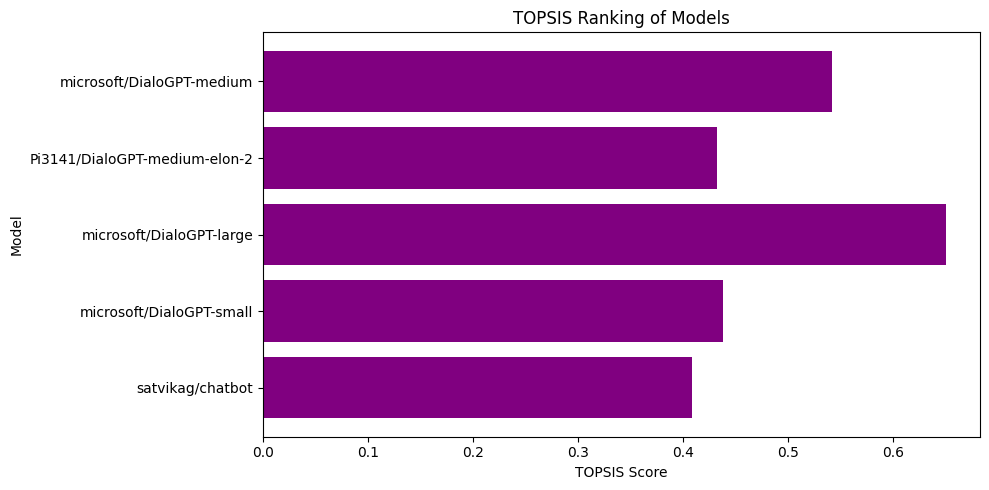

TOPSIS Bar Graph saved to topsis_BarGraph.png


In [11]:
# Plotting TOPSIS Bar Graph
plt.figure(figsize=(10, 5))
plt.barh(result_topsis['Unnamed: 0'], result_topsis['Topsis Score'], color='purple')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('topsis_BarGraph.png')
plt.show()

print("TOPSIS Bar Graph saved to topsis_BarGraph.png")

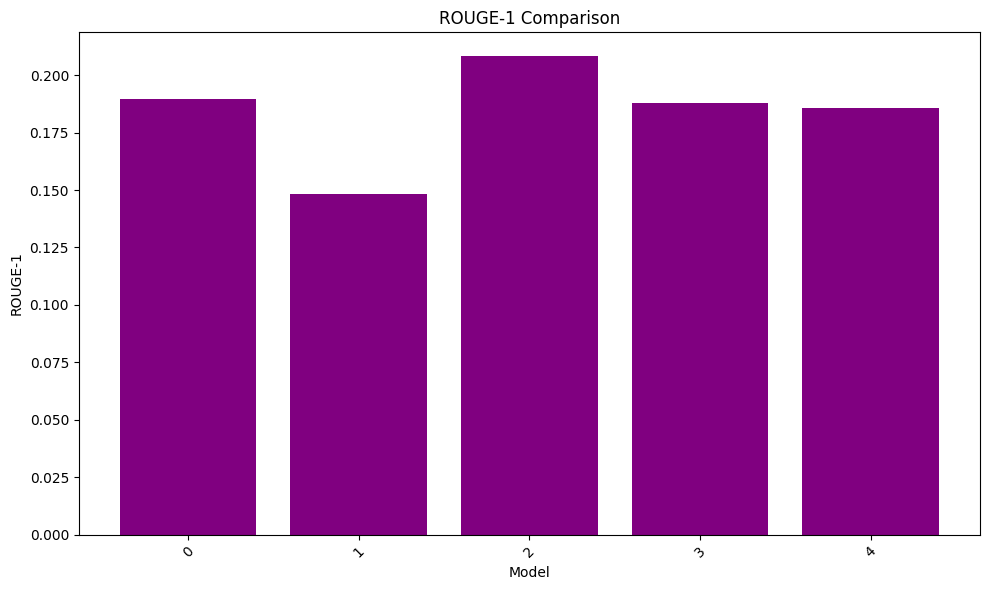

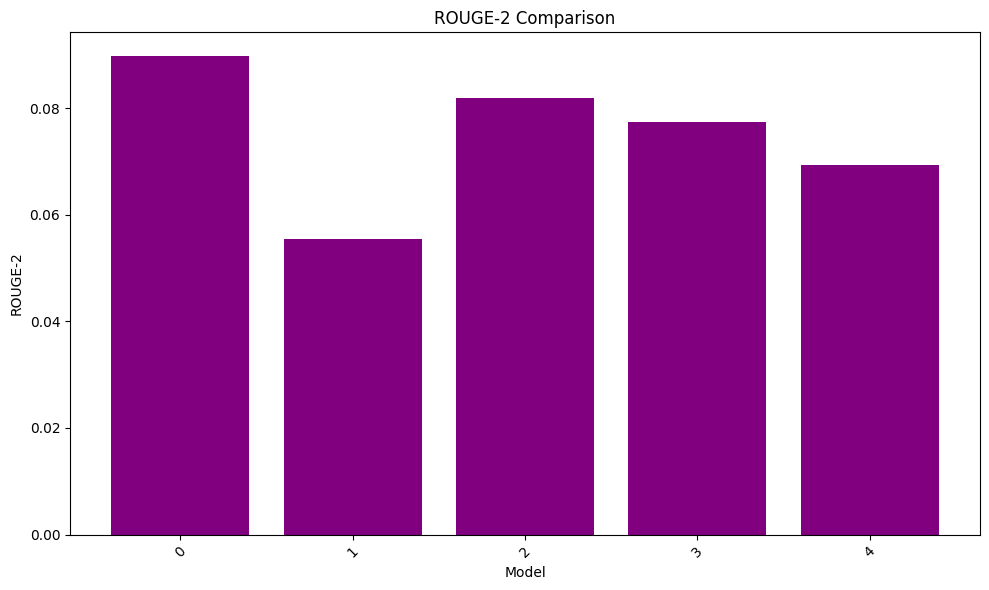

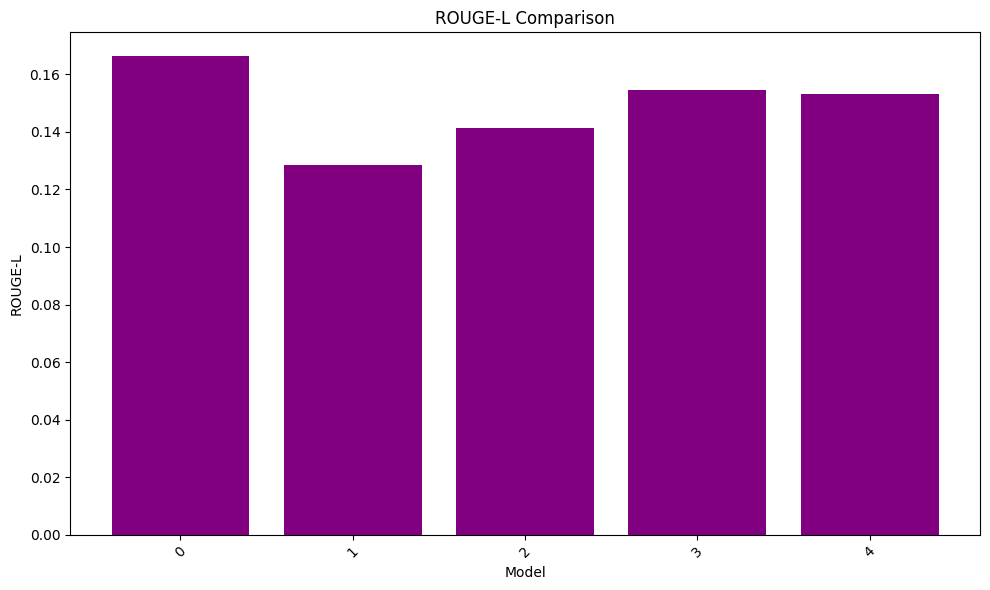

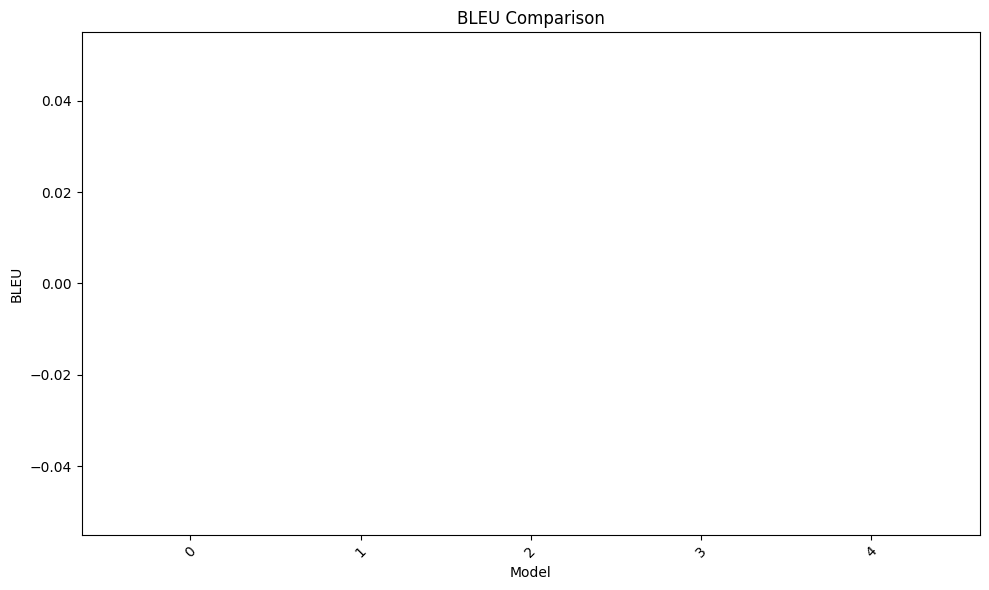

In [12]:
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L','BLEU']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data[metric], color='purple')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()


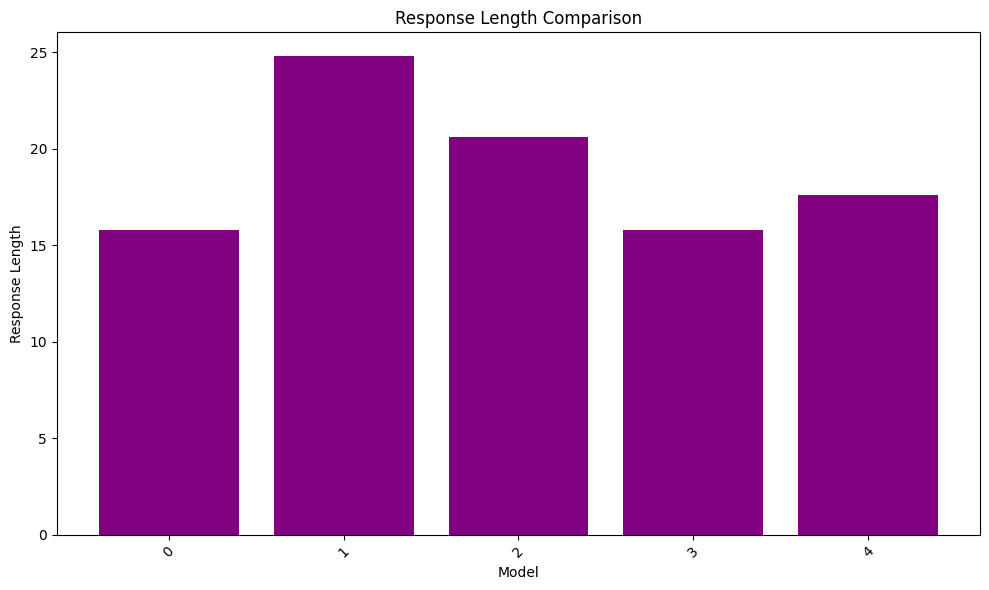

In [13]:
# Plotting response length
plt.figure(figsize=(10, 6))
plt.bar(data.index, data['Response Length'], color='purple')
plt.xlabel('Model')
plt.ylabel('Response Length')
plt.title('Response Length Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('response_length_comparison.png')
plt.show()
